In [1]:
### import importlib
import spacy

import sys
import os
import re

import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('words')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
english_vocab = set(words.words())

nlp = spacy.load("en_core_web_sm")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity

import pandas as pd
import networkx as nx
from textblob import TextBlob

# Add the 'src' directory to the system path
sys.path.append(os.path.abspath('../src'))
src_path = os.path.abspath('../src')

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package words to
[nltk_data]     /Users/jorge.mayorga/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jorge.mayorga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jorge.mayorga/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jorge.mayorga/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jorge.mayorga/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jorge.mayorga/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jorge.mayorga/nltk_data...
[nltk_data]   Package stopwords i

True

In [2]:
# Import classes from the modules using their correct filenames
from DataLoaderClass import DataLoader

In [3]:
# Initialize paths
BIB_FILE_PATH = '../examples/EX2_POWER_SYSTEM_FPGA_FREQUENCY_ESTIMATORS/index.bib'
PDF_FOLDER_PATH = '../examples/EX2_POWER_SYSTEM_FPGA_FREQUENCY_ESTIMATORS/files'

In [4]:
# Step 1: Data Loading and Processing
loader = DataLoader(BIB_FILE_PATH, PDF_FOLDER_PATH)
processed_data = loader.load_and_process()


Matching process completed.
Total references matched: 53 out of 53
Unmatched References: 0

Unmatched PDF Folders: 0


In [5]:
# -------------------------------------------------------------- #
# -- EDA M4 :: Quotes & Cites ---------------------------------- #
# -------------------------------------------------------------- #
from eda.m4_quotes_analysis import Processor
from eda.m4_quotes_analysis import Visualizer
from eda.m4_quotes_analysis import Reporter
# -------------------------------------------------------------- #

# Data
data = processed_data

# Process data
processor = Processor(data)
visualizer = Visualizer()
reporter = Reporter()

In [6]:
#################################################################################
### Function 1 => Most Frequent Quotes (Table & Barplot)
#################################################################################

In [7]:
def split_long_word_with_vocab(word, vocabulary):
    """
    Split a long word into subwords using a predefined English vocabulary.
    """
    subwords = []
    current = word.lower()
    while current:
        match = None
        for i in range(len(current), 0, -1):
            substring = current[:i]
            if substring in vocabulary:
                match = substring
                break
        if match:
            subwords.append(match)
            current = current[len(match):]
        else:
            subwords.append(current)  # Keep as is if no match
            break
    return subwords

def clean_and_split_text_with_vocab(plain_text, vocabulary):
    """
    Clean and split text using vocabulary-based splitting.
    """
    # Lowercase and remove non-alphabetic characters
    plain_text = re.sub(r'[^a-zA-Z\s]', ' ', plain_text.lower())

    # Tokenize the text
    tokens = word_tokenize(plain_text)

    # Remove stop words and single characters
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]

    # Split concatenated words using the vocabulary
    split_tokens = []
    for token in tokens:
        if len(token) > 10:  # Treat long words as concatenated
            split_tokens.extend(split_long_word_with_vocab(token, vocabulary))
        else:
            split_tokens.append(token)

    # Lemmatize the words with SpaCy
    lemmatized_words = []
    for token in nlp(" ".join(split_tokens)):
        if token.is_alpha and not token.is_stop:
            lemmatized_words.append(token.lemma_)

    # Remove domain-specific noise words
    noise_words = {"doi", "org", "http", "https", "www"}
    lemmatized_words = [word for word in lemmatized_words if word not in noise_words]
    
    return lemmatized_words

def process_document(doc, vocabulary):
    """
    Process a single document:
    - Cleans and tokenizes plain_text.
    - Splits authors into a list.
    """
    # Extract and clean plain_text
    plain_text = doc.get('plain_text', '')
    words = clean_and_split_text_with_vocab(plain_text, vocabulary)

    # Split authors into a list
    authors_raw = doc.get('bibliographic_metadata', {}).get('author', '')
    authors = [author.strip() for part in authors_raw.split(",") for author in part.split(" and ")]

    # Add the processed data to the document
    doc['words'] = words
    doc['authors'] = authors

    return doc


def process_documents(data, vocabulary):
    """
    Process a list of documents using the vocabulary.
    """
    return [process_document(doc, vocabulary) for doc in data]

In [8]:
# Process the documents
no_one_letter_english_vocab = [word for word in english_vocab if len(word) > 1]
processed_data = process_documents(data, no_one_letter_english_vocab)

In [9]:
def flatten_metadata(docs):
    """
    Flatten the bibliographic_metadata into individual columns for each document.
    """
    flattened_docs = []
    for doc in docs:
        # Extract bibliographic_metadata and flatten it
        metadata = doc.pop("bibliographic_metadata", {})
        flattened_doc = {**doc, **metadata}  # Merge metadata into the main doc
        flattened_docs.append(flattened_doc)
    return flattened_docs

# Flatten the metadata in processed_data
flattened_data = flatten_metadata(processed_data)

# Convert to a pandas DataFrame for tabular representation
import pandas as pd
df = pd.DataFrame(flattened_data)


In [45]:
# Use your DataFrame
df = pd.DataFrame(flattened_data)
df['joined_words'] = df['words'].apply(lambda words: ' '.join(words) if isinstance(words, list) else '')

In [48]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

def train_word2vec_model(author_name, df):
    """
    Train a Word2Vec model on all documents of a specific author.
    """
    # Filter documents by the given author
    author_docs = df[df['authors'].apply(lambda x: author_name in x)]['joined_words']
    
    # Tokenize words in all documents
    tokenized_docs = [word_tokenize(doc.lower()) for doc in author_docs if isinstance(doc, str)]
    
    # Train the Word2Vec model
    model = Word2Vec(sentences=tokenized_docs, vector_size=100, window=5, min_count=1, workers=4)
    
    return model

def recommend_context_words(word, model, top_n=5):
    """
    Find words most similar to the input word using the Word2Vec model.
    """
    if word in model.wv:
        # Get the top N most similar words
        similar_words = model.wv.most_similar(word, topn=top_n)
        return similar_words
    else:
        return f"'{word}' not found in the vocabulary."


In [49]:
# Example usage
author_name = "Chughtai"
input_word = "harmonics"

# Train the Word2Vec model for a specific author
author_model = train_word2vec_model(author_name, df)

In [50]:
# Get recommendations
recommended_words = recommend_context_words(input_word, author_model, top_n=20)
print(recommended_words)

[('frequency', 0.3139091432094574), ('phase', 0.3130474388599396), ('test', 0.3085609972476959), ('jaimeg', 0.29295074939727783), ('sthe', 0.29214727878570557), ('number', 0.2820521891117096), ('well', 0.2759539783000946), ('control', 0.27100300788879395), ('simulation', 0.2673923373222351), ('show', 0.2645000219345093), ('sthis', 0.26361462473869324), ('estimator', 0.2630468010902405), ('power', 0.25569844245910645), ('propose', 0.2556129992008209), ('variation', 0.2541202902793884), ('section', 0.2478303164243698), ('ion', 0.24703849852085114), ('need', 0.2465755045413971), ('linear', 0.24469923973083496), ('sec', 0.24341973662376404)]


In [52]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

def recommend_words_lda(author_name, input_word, df, top_n=5):
    """
    Recommend words based on topics identified by LDA for a given author and input word.
    """
    # Filter documents for the author
    filtered_df = df[df['authors'].apply(lambda x: isinstance(x, list) and author_name in x)]
    print(f"Number of documents for '{author_name}': {len(filtered_df)}")
    
    # Check if the filtered DataFrame is empty
    if filtered_df.empty:
        raise ValueError(f"No valid documents found for author '{author_name}'.")

    # Clean and validate the joined_words column
    author_docs = filtered_df['joined_words'].dropna().apply(str).str.strip()
    author_docs = author_docs[author_docs != '']  # Remove empty strings
    
    print(f"filtered_df: {len(filtered_df)}")
    print(f"Number of valid documents: {len(author_docs)}")
    
    if author_docs.empty:
        raise ValueError(f"No valid text data found for author '{author_name}'.")

    # Create a document-term matrix
    vectorizer = CountVectorizer(max_features=1000, stop_words='english')
    doc_term_matrix = vectorizer.fit_transform(author_docs)

    # Debug: Check vocabulary size
    vocab_size = len(vectorizer.get_feature_names_out())
    print(f"Vocabulary size: {vocab_size}")
    if vocab_size == 0:
        raise ValueError("Empty vocabulary; no valid words to process.")

    # Train LDA
    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda.fit(doc_term_matrix)

    # Get topics for the input word
    word_index = vectorizer.vocabulary_.get(input_word.lower())
    if word_index is None:
        return f"'{input_word}' not found in the vocabulary."

    # Topic distribution for the word
    word_topic_distribution = lda.components_[:, word_index]
    related_words = lda.components_.argsort(axis=1)[:, -top_n:]

    # Return top words for each topic
    feature_names = vectorizer.get_feature_names_out()
    return {f"Topic {i+1}": [feature_names[idx] for idx in related_words[i]] for i in range(lda.n_components)}


recommended_words = recommend_words_lda("Chughtai", "harmonics", df)
print(recommended_words)


Number of documents for 'Chughtai': 1
filtered_df: 1
Number of valid documents: 1
Vocabulary size: 1000
{'Topic 1': ['power', 'method', 'filter', 'cid', 'frequency'], 'Topic 2': ['lockedas', 'loop', 'ls', 'li', 'minim'], 'Topic 3': ['lockedas', 'loop', 'ls', 'li', 'minim'], 'Topic 4': ['lockedas', 'loop', 'ls', 'li', 'minim'], 'Topic 5': ['lockedas', 'loop', 'ls', 'li', 'minim']}


In [44]:
print(df[['authors', 'joined_words']].head())

                                             authors joined_words
0    [Chughtai, Aamir Hussain, Awan, Muhammad Saqib]             
1                             [Yan, Ziming, Xu, Yan]             
2  [Zhao, Junbo, Netto, Marcos, Huang, Zhenyu, Yu...             
3                                                 []             
4  [Arablouei, Reza, Werner, Stefan, Dogancay, Ku...             


In [53]:
from gensim.models import Word2Vec

def train_word2vec_model(df):
    # Use the 'joined_words' column to train Word2Vec
    tokenized_docs = [doc.split() for doc in df['joined_words'] if isinstance(doc, str)]
    model = Word2Vec(sentences=tokenized_docs, vector_size=100, window=5, min_count=1, workers=4)
    return model

def recommend_similar_words_w2v(author_name, input_word, model, top_n=5):
    if input_word in model.wv:
        return model.wv.most_similar(input_word, topn=top_n)
    else:
        return f"'{input_word}' not found in the vocabulary."

# Example usage
word2vec_model = train_word2vec_model(df)
recommendations = recommend_similar_words_w2v("Chughtai", "frequency", word2vec_model)
print(recommendations)

[('variation', 0.9857138395309448), ('change', 0.984373152256012), ('instantaneous', 0.9821791648864746), ('rate', 0.9808174967765808), ('deviation', 0.9806910753250122)]


In [56]:
from sklearn.cluster import KMeans

def cluster_words(df, n_clusters=5):
    # Vectorize words
    vectorizer = CountVectorizer(max_features=1000, stop_words='english')
    doc_term_matrix = vectorizer.fit_transform(df['joined_words'])
    
    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(doc_term_matrix)
    
    # Assign cluster labels
    df['cluster'] = kmeans.labels_
    return df

# Example usage
clustered_df = cluster_words(df, n_clusters=2)
print(clustered_df[['joined_words', 'cluster']])

                                         joined_words  cluster
0   electrical engineering original paper estimati...        0
1   article accept publication future issue journa...        0
2   article accept publication future issue journa...        0
3   international journal trend research developme...        0
4   th ieee international workshop computational a...        0
5   sci int lahore issn coden sinte new approach f...        0
6   simple frequency estimator power system sha fi...        0
7   ieee transaction s industrial inform ics linea...        0
8   robust estimation fundamental frequency positi...        0
9   new approach power system frequency estimation...        0
10  electric power system research content list av...        0
11  ie eetransactionsonpowerdelivery vol july appl...        0
12  solar energy content list available science ir...        0
13  avrupa bilim teknoloji dergisi european journa...        0
14  jes vol january jesaun electrical engineering ...  

/opt/anaconda3/envs/ML-Master/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Shape of document-term matrix: (53, 1000)
Percentage of non-zero values: 40.68%
Explained variance ratio: 1.00


/opt/anaconda3/envs/ML-Master/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


         joined_words
cluster              
0                  49
1                   1
2                   1
3                   1
4                   1


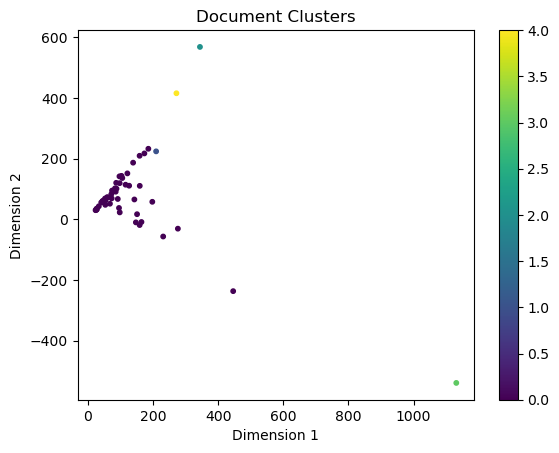

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Create the Document-Term Matrix
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(df['joined_words'])

# Debug: Check sparsity
print(f"Shape of document-term matrix: {doc_term_matrix.shape}")
print(f"Percentage of non-zero values: {doc_term_matrix.nnz / (doc_term_matrix.shape[0] * doc_term_matrix.shape[1]) * 100:.2f}%")

# Step 2: Apply TruncatedSVD for Dimensionality Reduction
svd = TruncatedSVD(n_components=50, random_state=42)  # Reduce to 50 dimensions
reduced_matrix = svd.fit_transform(doc_term_matrix)

# Debug: Check variance explained
print(f"Explained variance ratio: {svd.explained_variance_ratio_.sum():.2f}")

# Step 3: Apply K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(reduced_matrix)

# Debug: View cluster distribution
print(df[['joined_words', 'cluster']].groupby('cluster').count())

# Step 4: Visualize the Clusters (Optional, for 2D projection)
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], c=df['cluster'], cmap='viridis', s=10)
plt.colorbar()
plt.title('Document Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()